In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import json
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize

In [10]:
ROOT_DIR = "/home/ibrahim/stock/data/processed"
YEARS = ["2020", "2021", "2022", "2023", "2024", "2025"]

data = {
    "2020": {
        "high_impact": [],
        "medium_impact": [],
        "low_impact": [],
        "news": []
    },
    "2021": {
        "high_impact": [],
        "medium_impact": [],
        "low_impact": [],
        "news": []
    },
    "2022": {
        "high_impact": [],
        "medium_impact": [],
        "low_impact": [],
        "news": []
    },
    "2023": {
        "high_impact": [],
        "medium_impact": [],
        "low_impact": [],
        "news": []
    },
    "2024": {
        "high_impact": [],
        "medium_impact": [],
        "low_impact": [],
        "news": []
    },
    "2025": {
        "high_impact": [],
        "medium_impact": [],
        "low_impact": [],
        "news": []
    }
}

for year in YEARS:
    PATHS = os.listdir(os.path.join(ROOT_DIR, year))
    
    for path in PATHS:

        with open(os.path.join(ROOT_DIR, year, path), "r") as file:

            if "high" in path:
                data[year]["high_impact"] = json.load(file)
            elif "medium" in path:
                data[year]["medium_impact"] = json.load(file)
            elif "low" in path:
                data[year]["low_impact"] = json.load(file)
            else:
                data[year]["news"] = json.load(file)


In [11]:
PLOTS_DIR = "/home/ibrahim/stock/plots"

corpus = {"2020": {}, "2021": {}, "2022": {}, "2023": {}, "2024": {}, "2025": {}}

for news in data:
    for impact in data[news]:

        if data[news][impact] is None:
            print(f"No data for {news} {impact}")

        if len(data[news][impact]) > 0:
            text = " ".join(data[news][impact])
            text = text.replace("nvidia", " ")

            tokens = word_tokenize(text)

            corpus[news][impact] = text

            if os.path.exists(os.path.join(PLOTS_DIR, f"{news}_{impact}.png")):
                print(f"Already exists {news} {impact}")
                continue
            
            wordcloud = WordCloud(width=800, height=400, background_color="white", max_words=150).generate(text)

            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation="bilinear")
            plt.axis("off")
            plt.title(f"{news} {impact} Word Cloud")
            plt.savefig(os.path.join(PLOTS_DIR, f"{news}_{impact}.png"))
            plt.close()

Already exists 2020 high_impact
Already exists 2020 medium_impact
Already exists 2020 news
Already exists 2021 high_impact
Already exists 2021 medium_impact
Already exists 2021 news
Already exists 2022 high_impact
Already exists 2022 medium_impact
Already exists 2022 news
Already exists 2023 high_impact
Already exists 2023 medium_impact
Already exists 2023 news
Already exists 2024 high_impact
Already exists 2024 medium_impact
Already exists 2024 low_impact


KeyboardInterrupt: 

In [ ]:
import cupy as cp

ROOT_DIR = "/home/ibrahim/stock/data"

embeddings = cp.array([])

for year in YEARS:
    PATHS = os.listdir(os.path.join(ROOT_DIR, year))

    for path in PATHS:

        with open(os.path.join(ROOT_DIR, year, path), "r") as file:
            data = json.load(file)

            for article in data["articles"]:

                if embeddings.shape[0] == 0:
                    embeddings = cp.array(article["embedding"])
                else:
                    embeddings = cp.vstack((embeddings, cp.array(article["embedding"])))

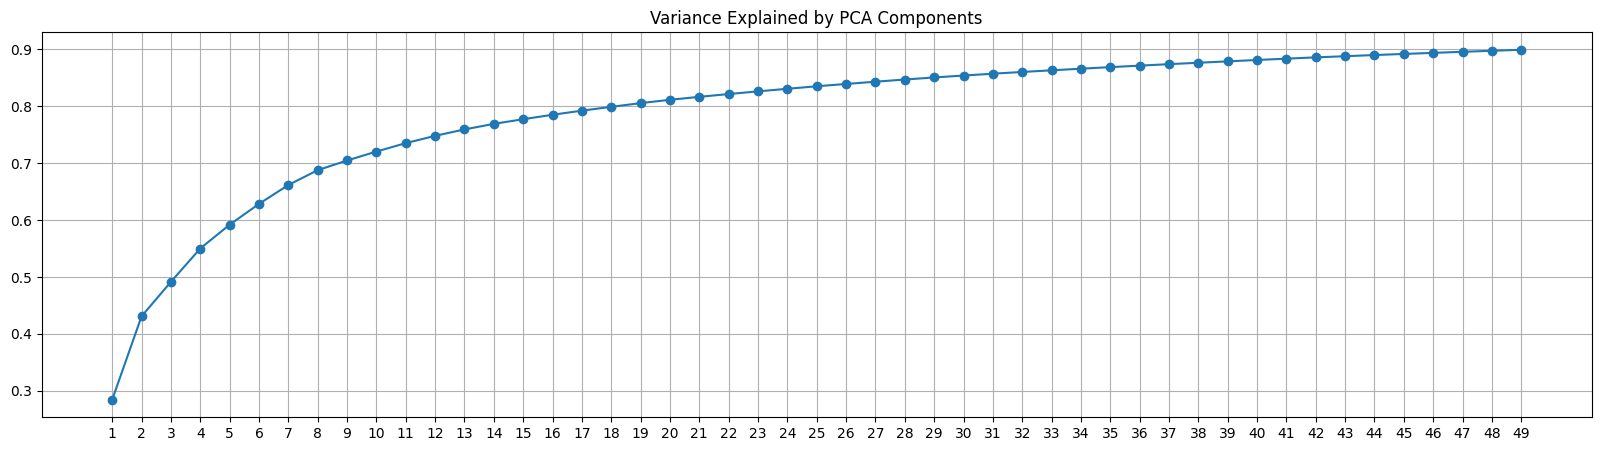

In [13]:
from cuml.decomposition import PCA

variances = []

for k in range(1, 50):
    pca = PCA(n_components=k)
    pca.fit(embeddings)

    variances.append(pca.explained_variance_ratio_.sum().get())

    if pca.explained_variance_ratio_.sum().get() > 0.95:
        print(f"95% variance explained with {k} components")
        break

plt.figure(figsize=(20, 5))
plt.grid(True)
plt.title("Variance Explained by PCA Components")
plt.xticks(range(1,50))
plt.plot(range(1,50), variances, marker='o')
plt.savefig(os.path.join(PLOTS_DIR, "pca_variance_explained.png"))

In [14]:
from cuml.cluster import DBSCAN, KMeans

kmeans = KMeans(n_clusters=10, random_state=0)

dbscan = DBSCAN(eps=0.5, min_samples=5)

dbscan_clusters = dbscan.fit_predict(embeddings)

kmeans_clusters = kmeans.fit_predict(embeddings)

/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/cuml/internals/api_decorators.py:405: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return init_func(self, *args, **filtered_kwargs)


[2025-04-12 19:32:06.292] [CUML] [warning] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


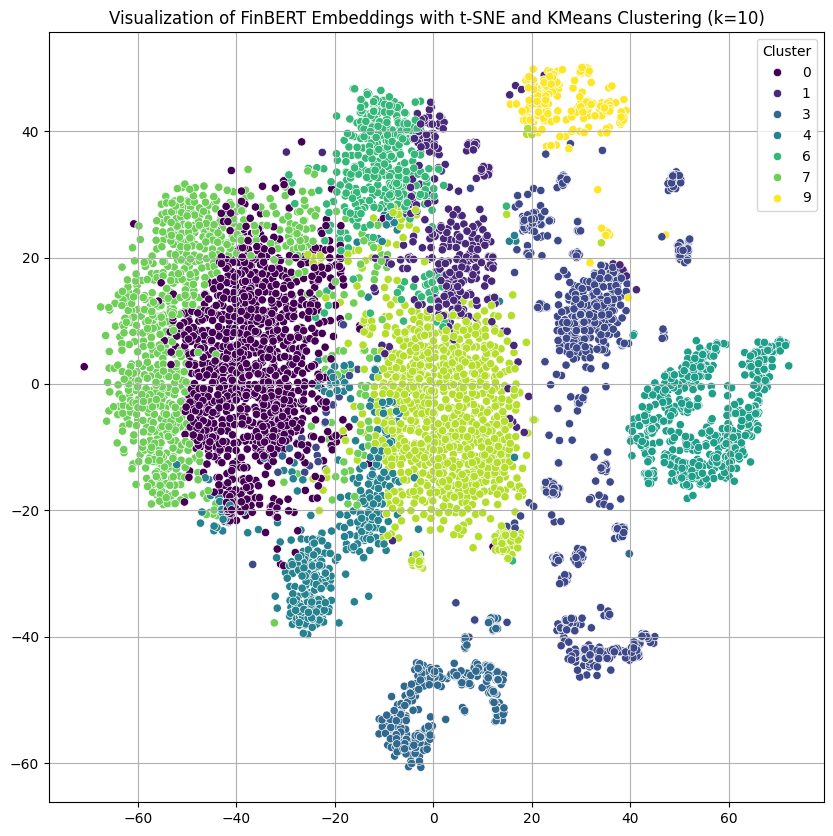

In [15]:
from cuml.decomposition import PCA
from cuml.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, perplexity=50, n_neighbors=500, n_iter=2000, init="pca")
tsne_embeddings = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 10))
plt.title("Visualization of FinBERT Embeddings with t-SNE and KMeans Clustering (k=10)")
sns.scatterplot(x=tsne_embeddings[:, 0].get(), y=tsne_embeddings[:, 1].get(), hue=kmeans_clusters.get(), palette="viridis")
plt.grid(True)
plt.legend(title="Cluster")
plt.savefig(os.path.join(PLOTS_DIR, "kmeans_tsne.png"))

In [16]:
import cupy as cp
import polars as pl
import datetime

ROOT_DIR = "/home/ibrahim/stock/data"

date_list = []

sentiment = cp.array([])
sia_scores = cp.array([])

for year in YEARS:
    PATHS = os.listdir(os.path.join(ROOT_DIR, year))

    for path in PATHS:

        with open(os.path.join(ROOT_DIR, year, path), "r") as file:
            data = json.load(file)

            for article in data["articles"]:
                if "published_parsed" in article.keys():
                    date = datetime.datetime(year = article["published_parsed"][0], month = article["published_parsed"][1], day = article["published_parsed"][2], hour = article["published_parsed"][3], minute = article["published_parsed"][4], second = article["published_parsed"][5])
                else:
                    date = None

                date_list.append(date)

                if sia_scores.shape[0] == 0:
                    sia_scores = cp.array([article["sentiment_scores"]["pos"], article["sentiment_scores"]["neu"], article["sentiment_scores"]["neg"], article["sentiment_scores"]["compound"]])
                else:
                    sia_scores = cp.vstack((sia_scores, cp.array([article["sentiment_scores"]["pos"], article["sentiment_scores"]["neu"], article["sentiment_scores"]["neg"], article["sentiment_scores"]["compound"]])))

                if sentiment.shape[0] == 0:
                    sentiment = cp.array([article["finbert_sentiment"]["positive"], article["finbert_sentiment"]["neutral"], article["finbert_sentiment"]["negative"]])
                else:
                    sentiment = cp.vstack((sentiment, cp.array([article["finbert_sentiment"]["positive"], article["finbert_sentiment"]["neutral"], article["finbert_sentiment"]["negative"]])))

In [17]:
date_series = pl.Series("date", date_list)

In [18]:
import polars as pl

df = pl.DataFrame({
    "date": date_series,
    "embeddings": embeddings.get(),
    "finbert_positive": sentiment[:, 0].get(),
    "finbert_neutral": sentiment[:, 1].get(),
    "finbert_negative": sentiment[:, 2].get(),
    "sia_positive": sia_scores[:, 0].get(),
    "sia_neutral": sia_scores[:, 1].get(),
    "sia_negative": sia_scores[:, 2].get(),
    "sia_compound": sia_scores[:, 3].get(),
    "kmeans_clusters": kmeans_clusters.get(),
    "dbscan_clusters": dbscan_clusters.get()
})

In [19]:
print(df.head())

shape: (5, 11)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ date      ┆ embedding ┆ finbert_p ┆ finbert_n ┆ … ┆ sia_negat ┆ sia_compo ┆ kmeans_cl ┆ dbscan_c │
│ ---       ┆ s         ┆ ositive   ┆ eutral    ┆   ┆ ive       ┆ und       ┆ usters    ┆ lusters  │
│ datetime[ ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ μs]       ┆ array[f64 ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ i32       ┆ i32      │
│           ┆ , 768]    ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2020-01-0 ┆ [0.589647 ┆ 0.041835  ┆ 0.943506  ┆ … ┆ 0.046     ┆ 0.8588    ┆ 2         ┆ 0        │
│ 8         ┆ ,         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 08:00:00  ┆ 0.507539, ┆           ┆           ┆   ┆           ┆           

In [21]:
df.write_parquet(os.path.join("../cache", "finbert_embeddings.parquet"))

In [25]:
df = pl.read_parquet(os.path.join("../cache", "finbert_embeddings.parquet"))
df = df.with_columns(pl.col("date").sort())

print(df.filter(pl.col("date") > datetime.datetime(2023, 1, 1)).head())

shape: (5, 11)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ date      ┆ embedding ┆ finbert_p ┆ finbert_n ┆ … ┆ sia_negat ┆ sia_compo ┆ kmeans_cl ┆ dbscan_c │
│ ---       ┆ s         ┆ ositive   ┆ eutral    ┆   ┆ ive       ┆ und       ┆ usters    ┆ lusters  │
│ datetime[ ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ μs]       ┆ array[f64 ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ i32       ┆ i32      │
│           ┆ , 768]    ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2023-01-0 ┆ [0.12877, ┆ 0.047397  ┆ 0.895755  ┆ … ┆ 0.057     ┆ 0.9982    ┆ 2         ┆ -1       │
│ 3         ┆ 0.404447, ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 08:00:00  ┆ …         ┆           ┆           ┆   ┆           ┆           

In [26]:
dates = df["date"].to_list()

print(dates)

[datetime.datetime(2020, 1, 2, 2, 30, 35), datetime.datetime(2020, 1, 2, 8, 0), datetime.datetime(2020, 1, 3, 8, 0), datetime.datetime(2020, 1, 5, 8, 0), datetime.datetime(2020, 1, 5, 8, 0), datetime.datetime(2020, 1, 5, 8, 0), datetime.datetime(2020, 1, 5, 8, 0), datetime.datetime(2020, 1, 5, 8, 0), datetime.datetime(2020, 1, 5, 8, 0), datetime.datetime(2020, 1, 6, 8, 0), datetime.datetime(2020, 1, 6, 8, 0), datetime.datetime(2020, 1, 6, 8, 0), datetime.datetime(2020, 1, 6, 8, 0), datetime.datetime(2020, 1, 6, 8, 0), datetime.datetime(2020, 1, 6, 8, 0), datetime.datetime(2020, 1, 6, 8, 0), datetime.datetime(2020, 1, 6, 8, 0), datetime.datetime(2020, 1, 6, 8, 0), datetime.datetime(2020, 1, 6, 8, 0), datetime.datetime(2020, 1, 7, 8, 0), datetime.datetime(2020, 1, 7, 8, 0), datetime.datetime(2020, 1, 8, 8, 0), datetime.datetime(2020, 1, 8, 8, 0), datetime.datetime(2020, 1, 8, 8, 0), datetime.datetime(2020, 1, 9, 8, 0), datetime.datetime(2020, 1, 9, 8, 0), datetime.datetime(2020, 1, 10, 8

In [ ]:
def sentiment_classifier(pos, neu, neg) -> str:
    if pos > neu and pos > neg:
        return str("positive")
    elif neu > pos and neu > neg:
        return str("neutral")
    else:
        return str("negative")
    
def sentiment_classifier2(pos, neg) -> str:
    if pos > neg:
        return str("positive")
    elif neg > pos:0.1
        return str("negative")
    
df = df.with_columns(
    pl.struct(["finbert_positive", "finbert_neutral", "finbert_negative"])
      .map_elements(lambda x: sentiment_classifier(x["finbert_positive"], x["finbert_neutral"], x["finbert_negative"]))
        .alias("finbert_sentiment"),
)

df = df.with_columns(
    pl.struct(["finbert_positive", "finbert_negative"])
      .map_elements(lambda x: sentiment_classifier2(x["finbert_positive"], x["finbert_negative"]))
        .alias("finbert_sentiment2"),
)

/tmp/ipykernel_6622/1627630123.py:15: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(
/tmp/ipykernel_6622/1627630123.py:21: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(


In [15]:
df = df.sort("date")

In [154]:
sentiments = df.group_by_dynamic("date", every="1mo").agg(pl.col("finbert_sentiment").value_counts())

In [155]:
sentiments

date,finbert_sentiment
datetime[μs],list[struct[2]]
2020-01-01 00:00:00,"[{""neutral"",74}, {""negative"",5}]"
2020-02-01 00:00:00,"[{""neutral"",76}, {""negative"",2}, {""positive"",1}]"
2020-03-01 00:00:00,"[{""positive"",2}, {""neutral"",73}, {""negative"",7}]"
2020-04-01 00:00:00,"[{""neutral"",74}, {""positive"",5}, {""negative"",4}]"
2020-05-01 00:00:00,"[{""neutral"",80}, {""positive"",4}]"
…,…
2024-11-01 00:00:00,"[{""positive"",15}, {""neutral"",102}, {""negative"",5}]"
2024-12-01 00:00:00,"[{""positive"",8}, {""negative"",6}, {""neutral"",133}]"
2025-01-01 00:00:00,"[{""negative"",10}, {""neutral"",123}, {""positive"",6}]"


In [156]:
struct_list = sentiments["finbert_sentiment"].to_list()

all_values = {
    "positive": [],
    "neutral": [],
    "negative": []
}

for struct in struct_list:
    new_vals = {
        "positive": 0,
        "neutral": 0,
        "negative": 0
    }
    for val in struct:
        if val["finbert_sentiment"] == "positive":
            new_vals["positive"] = val["count"]
        elif val["finbert_sentiment"] == "neutral":
            new_vals["neutral"] = val["count"]
        elif val["finbert_sentiment"] == "negative":
            new_vals["negative"] = val["count"]
    
    all_values["positive"].append(new_vals["positive"])
    all_values["neutral"].append(new_vals["neutral"])
    all_values["negative"].append(new_vals["negative"])


In [ ]:
    sentiments = sentiments.with_columns(
        pl.Series("positive", all_values["positive"]),
        pl.Series("neutral", all_values["neutral"]),
        pl.Series("negative", all_values["negative"])
    )

In [158]:
df_indicators = pl.read_csv("NVDA_10y.csv")

df_indicators_copy = df_indicators.clone()

df_indicators_copy = df_indicators_copy.with_columns(
    pl.col("date").str.strptime(pl.Datetime)
)

df_indicators = df_indicators.with_columns(
    pl.col("date").str.strptime(pl.Datetime)
)

df_indicators = df_indicators.filter(pl.col("date") >= sentiments["date"].min())

print(df_indicators.head())

shape: (5, 25)
┌─────────────┬──────────┬──────────┬──────────┬───┬──────────┬──────────┬────────────┬────────────┐
│ date        ┆ close    ┆ high     ┆ low      ┆ … ┆ ATR      ┆ obv      ┆ K          ┆ D          │
│ ---         ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---        ┆ ---        │
│ datetime[μs ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64      ┆ f64      ┆ f64        ┆ f64        │
│ ]           ┆          ┆          ┆          ┆   ┆          ┆          ┆            ┆            │
╞═════════════╪══════════╪══════════╪══════════╪═══╪══════════╪══════════╪════════════╪════════════╡
│ 2020-01-01  ┆ 5.885533 ┆ 6.459823 ┆ 5.757084 ┆ … ┆ 0.712383 ┆ 2.892641 ┆ -413.79992 ┆ -413.97401 │
│ 00:00:00    ┆          ┆          ┆          ┆   ┆          ┆          ┆ 3          ┆            │
│ 2020-02-01  ┆ 6.722944 ┆ 7.874261 ┆ 5.861137 ┆ … ┆ 0.751504 ┆ 3.034923 ┆ -475.17209 ┆ -434.26669 │
│ 00:00:00    ┆          ┆          ┆          ┆   ┆          ┆          ┆ 3

In [159]:
df_indicators_copy.columns

['date',
 'close',
 'high',
 'low',
 'open',
 'volume',
 'dividends',
 'stock splits',
 'sma_200',
 'macd',
 'signal_line',
 'macd_hist',
 'returns',
 'rsi',
 'bb_lower',
 'bb_upper',
 'roc',
 'hi_lo',
 'hi_close',
 'lo_close',
 'true_range',
 'ATR',
 'obv',
 'K',
 'D']

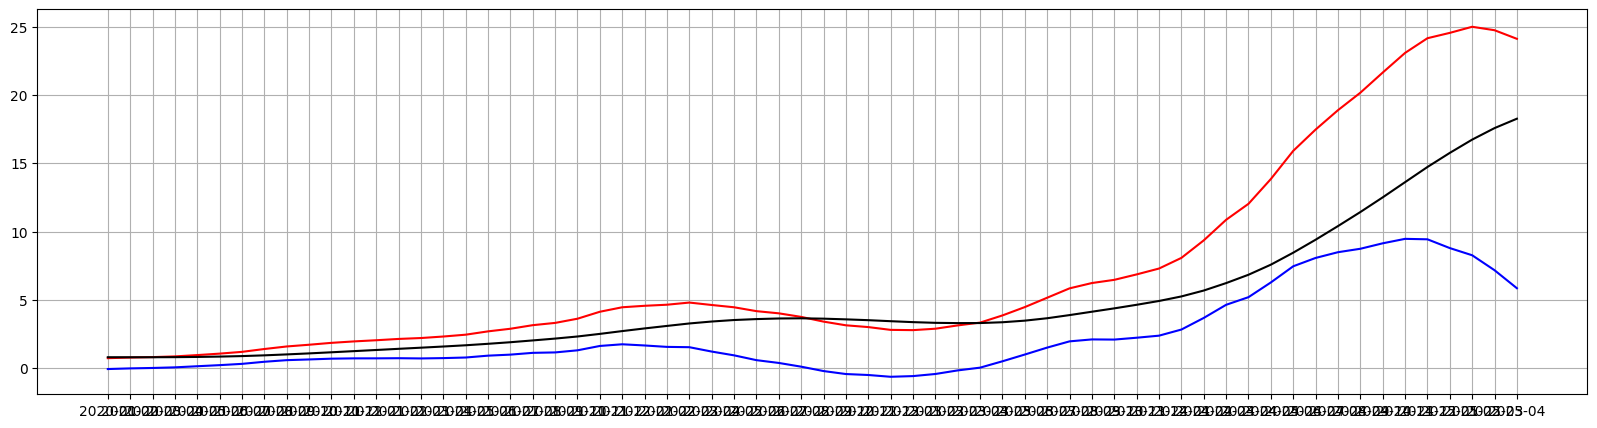

In [160]:
plt.figure(figsize=(20, 5))
plt.grid(True)

plt.plot(df_indicators["date"].dt.strftime("%Y-%m").to_list(), df_indicators["macd_hist"], label="Close Price", color="blue")
plt.plot(df_indicators["date"].dt.strftime("%Y-%m").to_list(), df_indicators["macd"], label="Close Price", color="red")
plt.plot(df_indicators["date"].dt.strftime("%Y-%m").to_list(), df_indicators["signal_line"], label="Close Price", color="black")

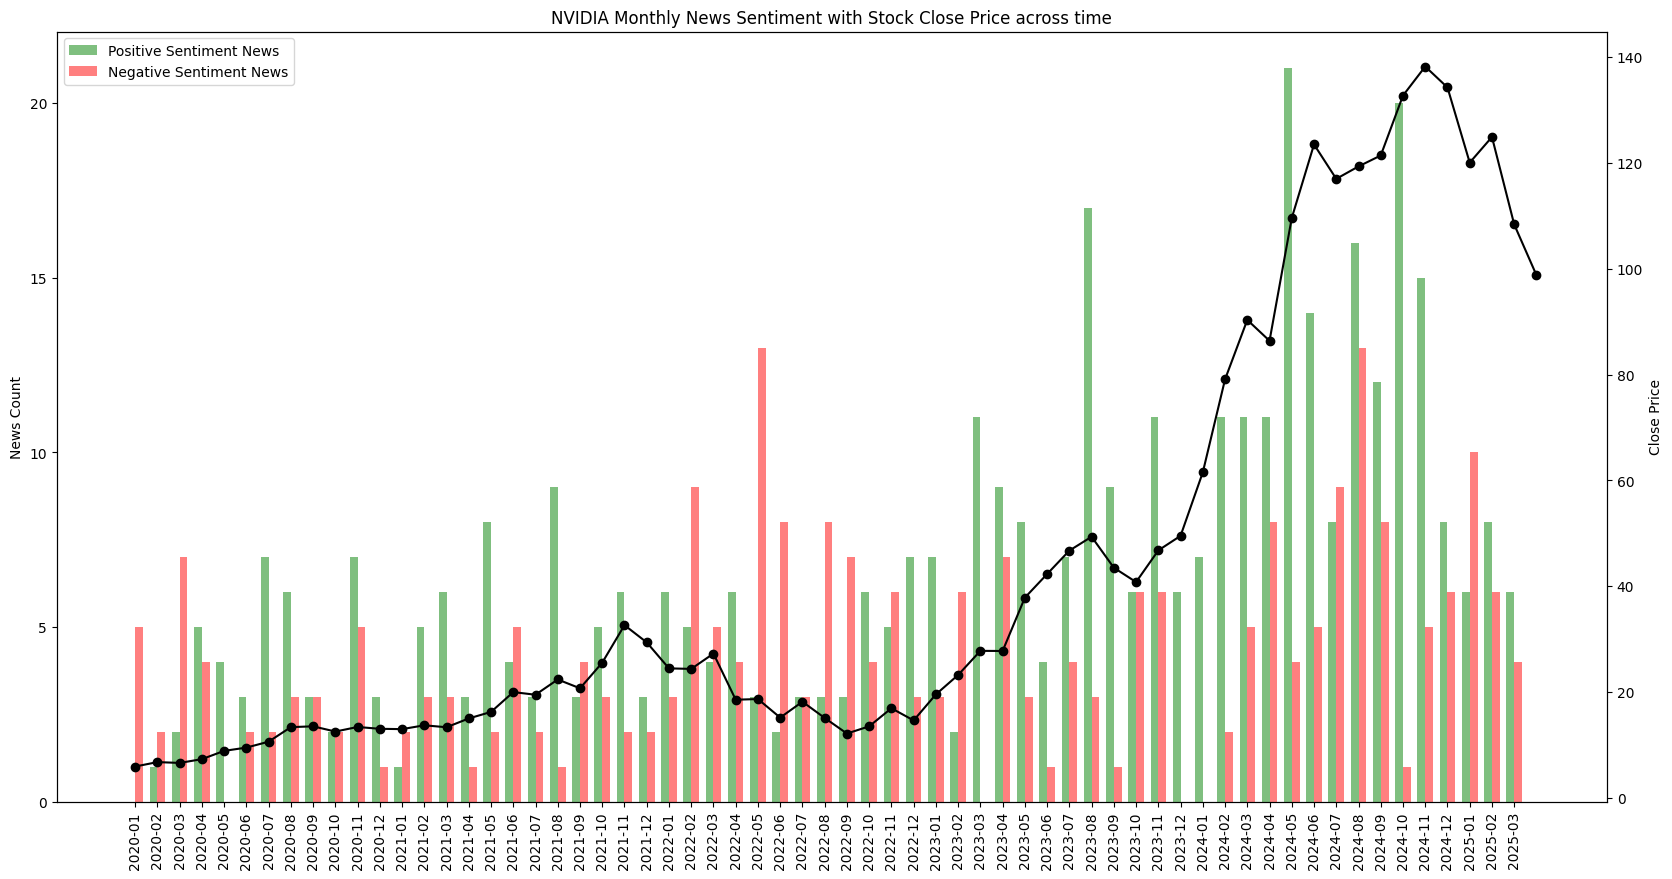

In [161]:
import numpy as np

fig, ax1 = plt.subplots()

fig.set_size_inches(20, 10)

ax2 = plt.twinx()

ax2.plot(df_indicators["date"].dt.strftime("%Y-%m").to_list(), df_indicators["close"].to_list(), label="Close Price", color="black", marker="o")

# get x positions based on the number of unique dates in sentiments dataframe
x = np.arange(len(sentiments["date"]))
width = 0.35

ax1.bar(x - width/2, sentiments["positive"].to_list(), width, color="green", alpha=0.5, label="Positive Sentiment News")
ax1.bar(x + width/2, sentiments["negative"].to_list(), width, color="red", alpha=0.5, label="Negative Sentiment News")

ax1.legend(loc="upper left")
# update x-tick labels
ax1.set_xticks(x)
ax1.set_xticklabels(sentiments["date"].dt.strftime("%Y-%m").to_list(), rotation=90)

ax1.set_yticks(range(0, 25, 5))
ax1.set_ylabel("News Count")

ax2.set_yticks(range(0, 160, 20))
ax2.set_ylabel("Close Price")

plt.title("NVIDIA Monthly News Sentiment with Stock Close Price across time")
plt.savefig(os.path.join(PLOTS_DIR, "sentiment_close_price.png"))

In [182]:
positive = sentiments["positive"].to_list()
negative = sentiments["negative"].to_list()

sent_up = []

for pos, neg in zip(positive, negative):
    if pos > neg:
        sent_up.append(True)
    else:
        sent_up.append(False)

returns = df_indicators_copy["returns"].fill_null(0).to_list()
returns_mask = [ret > 0 for ret in returns]

close = np.array(df_indicators["close"].to_list())
running_max = np.maximum.accumulate(close)
drawdown = (close - running_max) / running_max * 100

drawdown_up = [draw >= 0 for draw in drawdown]

drawdown_up

[True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False]

In [183]:
matrix = [
    [0,0],
    [0,0]
]

for sent, ret in zip(sent_up, drawdown_up):
    if sent and ret:
        matrix[0][0] += 1
    elif sent and not ret:
        matrix[0][1] += 1
    elif not sent and ret:
        matrix[1][0] += 1
    elif not sent and not ret:
        matrix[1][1] += 1

matrix

[[23, 20], [4, 16]]

In [184]:
import scipy.stats as stats

chi2, p, dof, expected = stats.chi2_contingency(matrix)

print(f"Chi2: {chi2}, p-value: {p}, dof: {dof}")
print(stats.chi2_contingency(matrix))

Chi2: 4.958502906976745, p-value: 0.025962675269696513, dof: 1
Chi2ContingencyResult(statistic=4.958502906976745, pvalue=0.025962675269696513, dof=1, expected_freq=array([[18.42857143, 24.57142857],
       [ 8.57142857, 11.42857143]]))


In [ ]:
import scipy.stats as stats

stats.chi2_contingency(
    
)

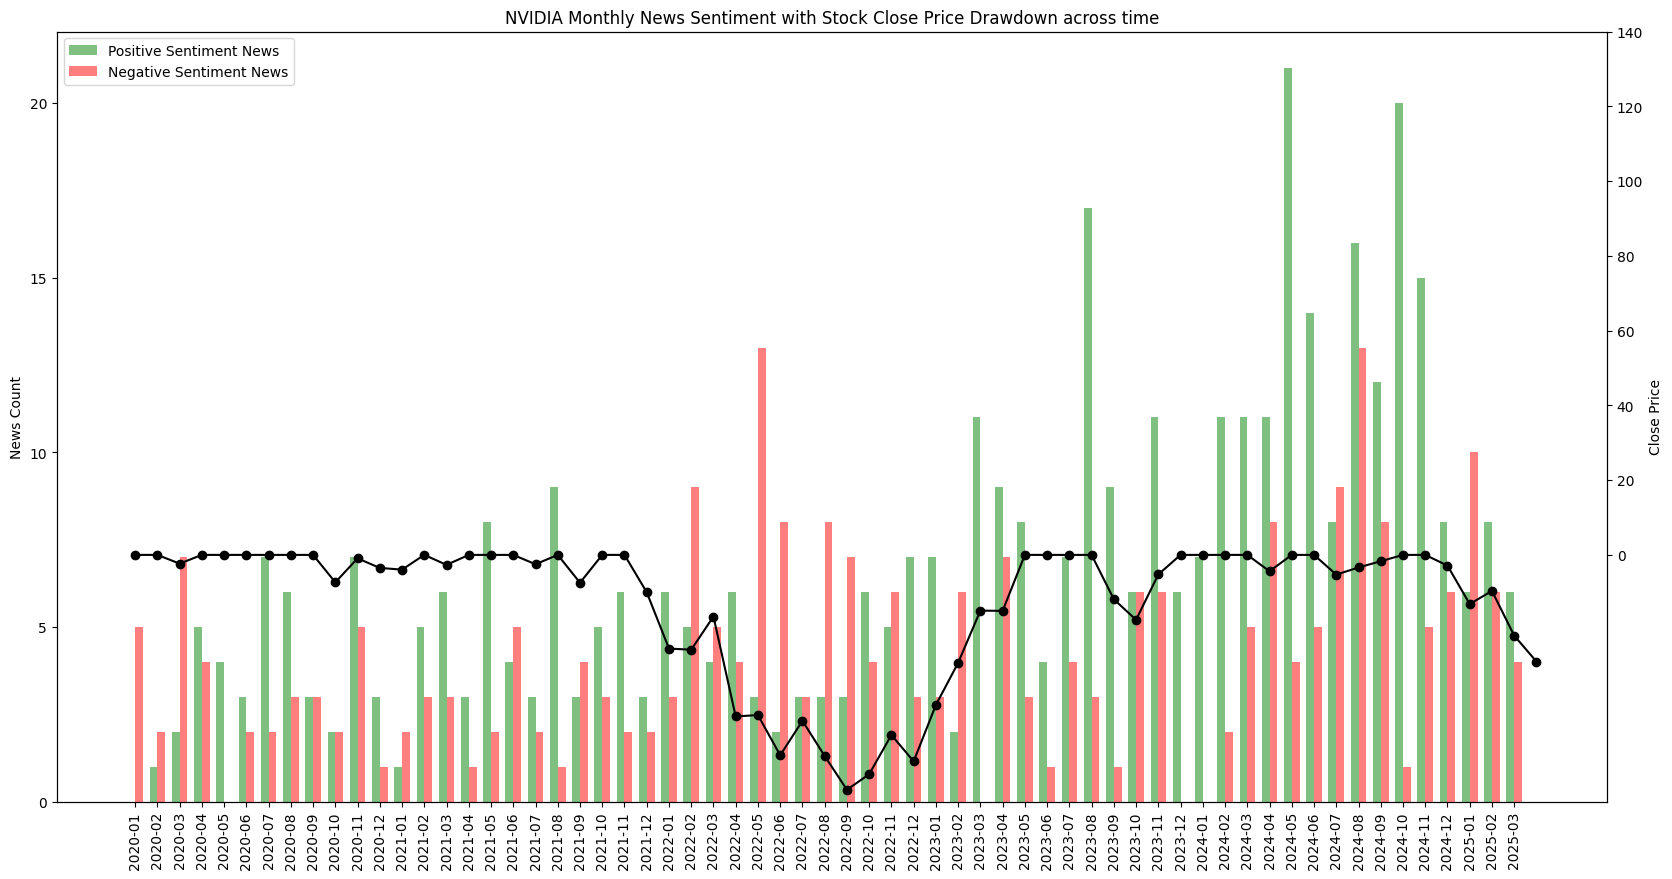

In [92]:
import numpy as np

fig, ax1 = plt.subplots()

fig.set_size_inches(20, 10)

ax2 = plt.twinx()

close = np.array(df_indicators["close"].to_list())
running_max = np.maximum.accumulate(close)
drawdown = (close - running_max) / running_max * 100
dates = df_indicators["date"].dt.strftime("%Y-%m").to_list()
ax2.plot(dates, drawdown, label="Drawdown", color="black", marker="o")

# get x positions based on the number of unique dates in sentiments dataframe
x = np.arange(len(sentiments["date"]))
width = 0.35

ax1.bar(x - width/2, sentiments["positive"].to_list(), width, color="green", alpha=0.5, label="Positive Sentiment News")
ax1.bar(x + width/2, sentiments["negative"].to_list(), width, color="red", alpha=0.5, label="Negative Sentiment News")

ax1.legend(loc="upper left")
# update x-tick labels
ax1.set_xticks(x)
ax1.set_xticklabels(sentiments["date"].dt.strftime("%Y-%m").to_list(), rotation=90)

ax1.set_yticks(range(0, 25, 5))
ax1.set_ylabel("News Count")

ax2.set_yticks(range(0, 160, 20))
ax2.set_ylabel("Close Price")

plt.title("NVIDIA Monthly News Sentiment with Stock Close Price Drawdown across time")
plt.savefig(os.path.join(PLOTS_DIR, "sentiment_drawdown_price.png"))

In [189]:
df_indicators_copy = df_indicators_copy.with_columns(
    (pl.col("close").diff(1)/pl.col("close").shift(1)).alias("returns")
)

df_indicators_copy = df_indicators_copy.with_columns(
    pl.col("returns").fill_null(0).alias("returns")
)

In [22]:
print(df_indicators_copy[["close", "returns"]].head(20))

shape: (20, 2)
┌──────────┬───────────┐
│ close    ┆ returns   │
│ ---      ┆ ---       │
│ f64      ┆ f64       │
╞══════════╪═══════════╡
│ 0.533142 ┆ 0.0       │
│ 0.48672  ┆ -0.087072 │
│ 0.482848 ┆ -0.007956 │
│ 0.544081 ┆ 0.126817  │
│ 0.599111 ┆ 0.101144  │
│ …        ┆ …         │
│ 1.505865 ┆ 0.074256  │
│ 1.68523  ┆ 0.119111  │
│ 1.75016  ┆ 0.038529  │
│ 2.267633 ┆ 0.295672  │
│ 2.62917  ┆ 0.159434  │
└──────────┴───────────┘


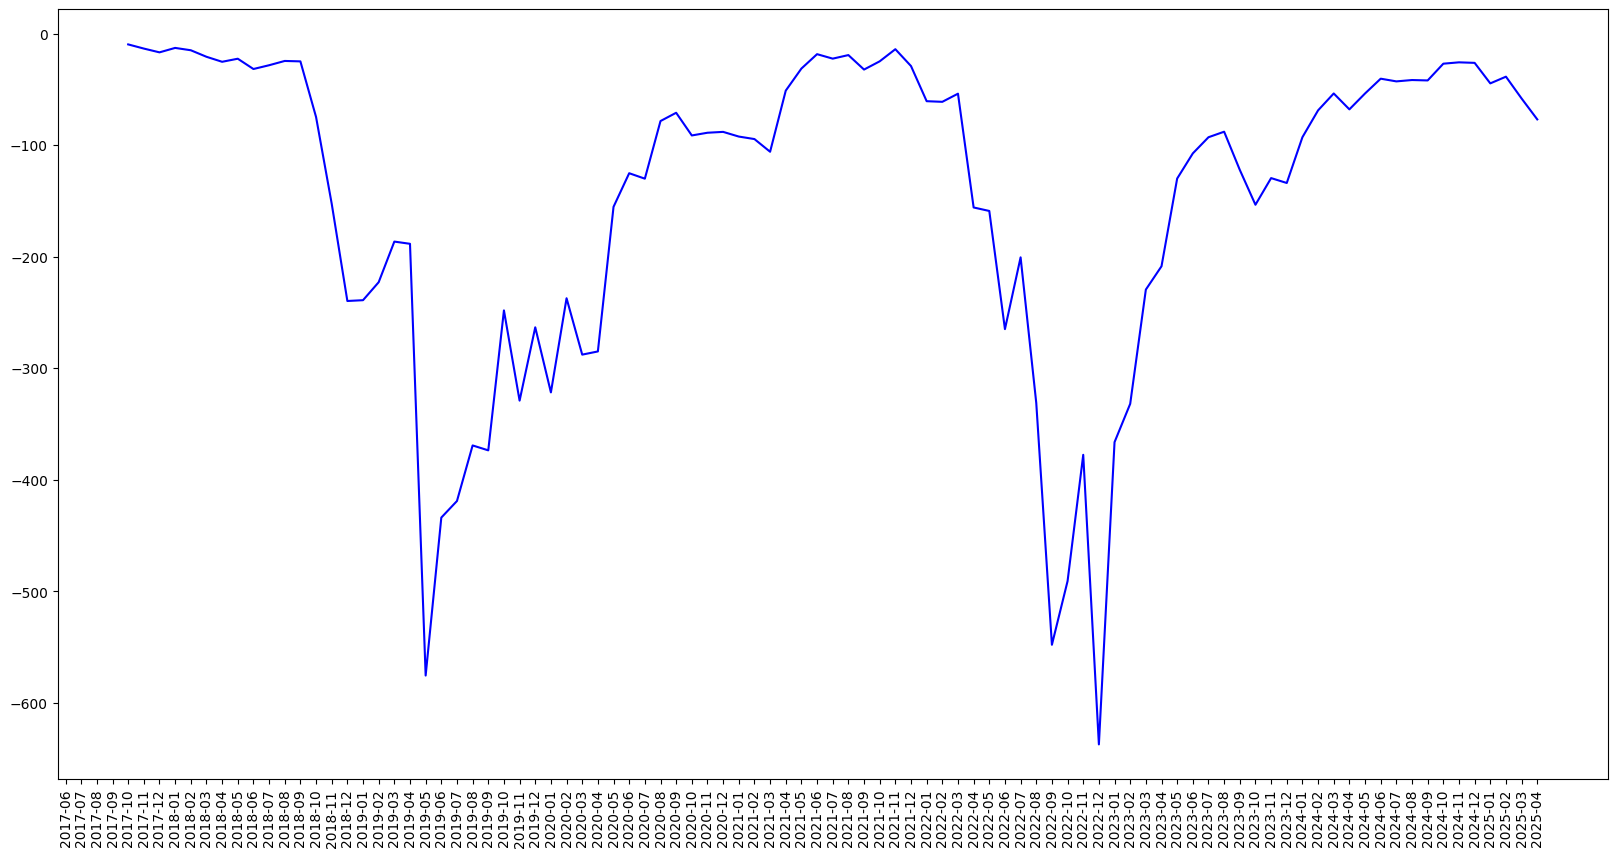

In [97]:
plt.figure(figsize=(20, 10))

plt.plot(df_indicators_copy["date"].dt.strftime("%Y-%m").to_list(), df_indicators_copy["rsi"].to_list(), label="Returns", color="blue")
plt.xticks(rotation=90)
plt.show()

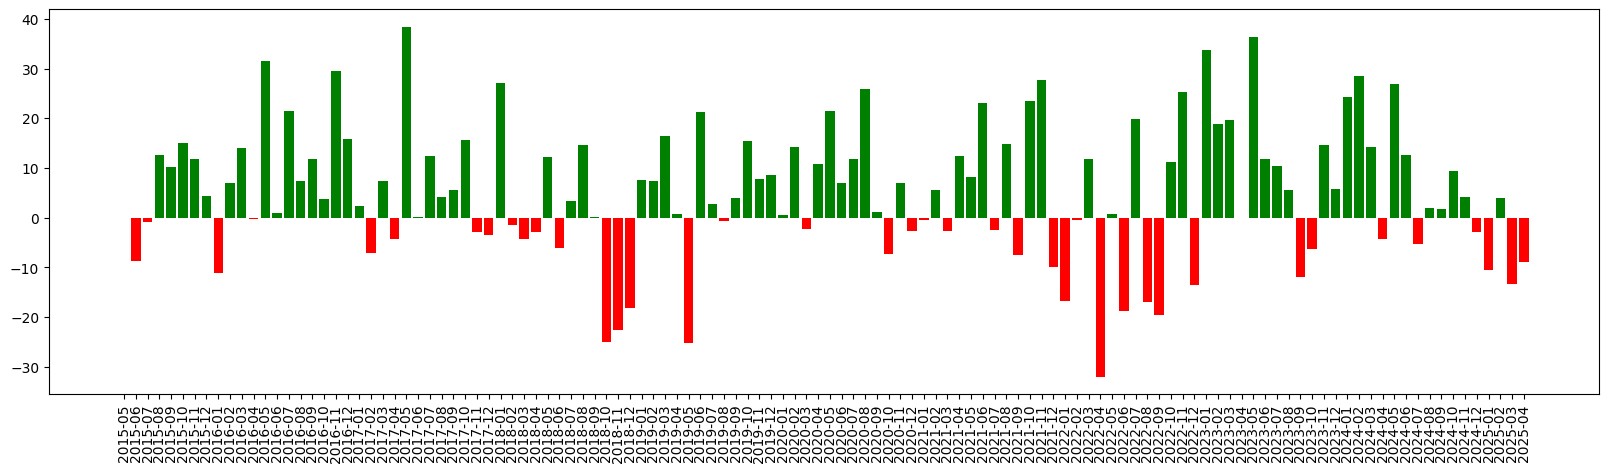

In [88]:
plt.figure(figsize=(20, 5))
colors = ["green" if x > 0 else "red" for x in df_indicators_copy["returns"].to_list()]
plt.bar(df_indicators_copy["date"].dt.strftime("%Y-%m").to_list(), (df_indicators_copy["returns"] * 100).to_list(), label="Returns", color=colors)
plt.xticks(rotation=90)
plt.show()

In [24]:
mean = df_indicators_copy["returns"].mean()
var = df_indicators_copy["returns"].var()
skew = df_indicators_copy["returns"].skew()
kurtosis = df_indicators_copy["returns"].kurtosis()

Mean: 0.05344142399289864
Variance: 0.01854518894431731
Skew: -0.05078393714302776
Kurtosis: 0.022242440104799144


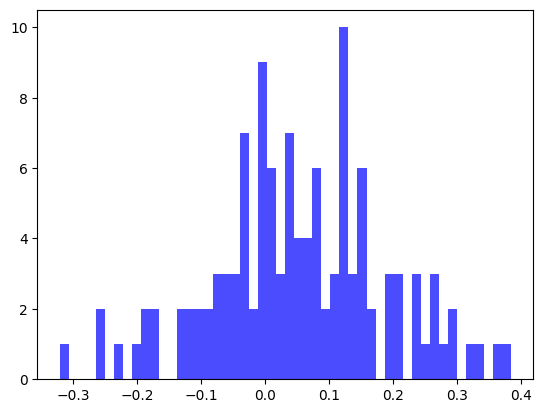

In [58]:
plt.hist(df_indicators_copy["returns"].fill_null(0).to_list(), bins=50, color="blue", alpha=0.7)

print(f"Mean: {mean}")
print(f"Variance: {var}")
print(f"Skew: {skew}")
print(f"Kurtosis: {kurtosis}")

In [207]:
import scipy.stats as stats

report = stats.anderson(df_indicators_copy["returns"].fill_null(0).to_list(), dist="norm")

print(report)

AndersonResult(statistic=0.2547023350676909, critical_values=array([0.558, 0.636, 0.763, 0.89 , 1.059]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.05344142399289866, scale=0.13618072163238568)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


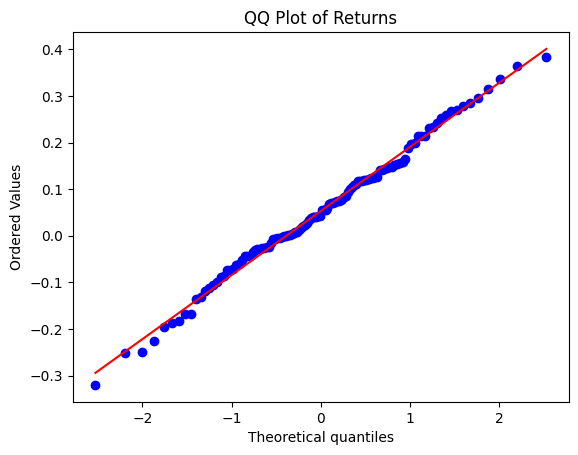

In [31]:
import numpy as np

import scipy.stats as stats

returns_np = np.array(df_indicators_copy["returns"])
stats.probplot(returns_np, dist="norm", plot=plt)
plt.title("QQ Plot of Returns")
plt.show()

In [197]:
df_yearly = df_indicators_copy.with_columns(pl.col("date").dt.year().alias("year")).group_by("year").agg([
        ((pl.col("returns") + 1).product() - 1).alias("yearly_return"),
        (pl.col("returns").std() * (12 ** 0.5)).alias("annual_volatility")
    ])

df_yearly = df_yearly.with_columns(
    (pl.col("yearly_return") > 0).alias("positive_year"),
)
print(df_yearly)

df_yearly = df_yearly.with_columns(
    (pl.col("yearly_return") > 0).alias("positive_year"),
)
print(df_yearly)

shape: (11, 4)
┌──────┬───────────────┬───────────────────┬───────────────┐
│ year ┆ yearly_return ┆ annual_volatility ┆ positive_year │
│ ---  ┆ ---           ┆ ---               ┆ ---           │
│ i32  ┆ f64           ┆ f64               ┆ bool          │
╞══════╪═══════════════╪═══════════════════╪═══════════════╡
│ 2021 ┆ 1.255211      ┆ 0.441648          ┆ true          │
│ 2015 ┆ 0.508277      ┆ 0.286193          ┆ true          │
│ 2020 ┆ 1.2223        ┆ 0.349655          ┆ true          │
│ 2018 ┆ -0.308152     ┆ 0.531072          ┆ false         │
│ 2025 ┆ -0.264272     ┆ 0.266046          ┆ false         │
│ …    ┆ …             ┆ …                 ┆ …             │
│ 2022 ┆ -0.502586     ┆ 0.628323          ┆ false         │
│ 2017 ┆ 0.819879      ┆ 0.428379          ┆ true          │
│ 2024 ┆ 1.712545      ┆ 0.420971          ┆ true          │
│ 2016 ┆ 2.269601      ┆ 0.431605          ┆ true          │
│ 2019 ┆ 0.76943       ┆ 0.405473          ┆ true          │
└──────┴─

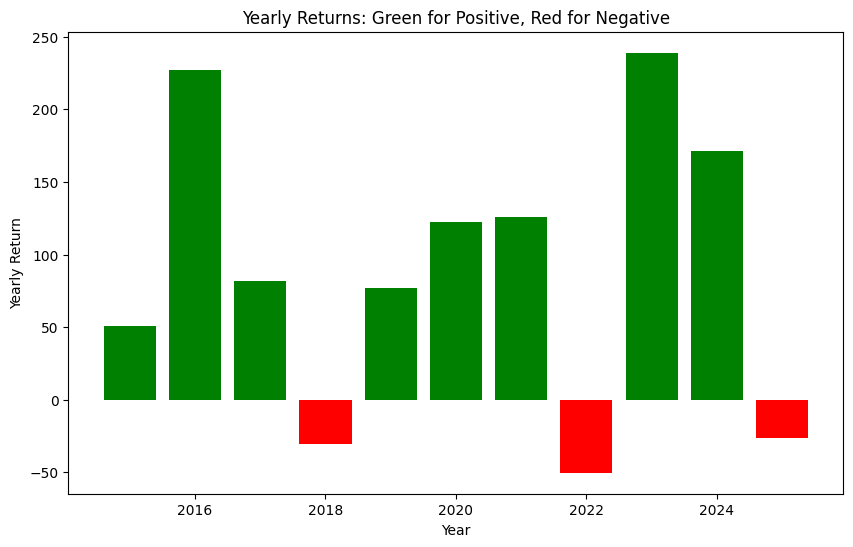

In [198]:
years = df_yearly["year"].to_list()
yearly_returns = (df_yearly["yearly_return"]*100).to_list()
yearly_vol = (df_yearly["annual_volatility"]*100).to_list()
colors = ["green" if positive else "red" for positive in df_yearly["positive_year"].to_list()]

plt.figure(figsize=(10,6))
plt.bar(years, yearly_returns, color=colors)
plt.xlabel("Year")
plt.ylabel("Yearly Return")
plt.title("Yearly Returns: Green for Positive, Red for Negative")
plt.show()

In [206]:
from scipy.stats import ttest_ind

mean_return = np.mean(yearly_returns)
mean_vol = np.mean(yearly_vol)


nasdaq_vol = np.mean([20.03, 15.63, 30.13, 20.57, 25.15, 30.57, 19.98, 13.88, 12.08, 18.84])
nasdaq_ret = np.mean([5.62, 34.02, -14.05, 7.35, 72.04, -0.38, 9.43, 19.48, 21.39, -0.63])

nasdaq_returns = [5.62, 34.02, -14.05, 7.35, 72.04, -0.38, 9.43, 19.48, 21.39, -0.63]
t_stat, p_val = ttest_ind(yearly_returns, nasdaq_returns, equal_var=False, alternative="two-sided")
print("T-statistic:", t_stat)
print("P-value:", p_val)

T-statistic: 2.396633552733233
P-value: 0.03496096918910104


In [26]:
from statsmodels.tsa.stattools import adfuller

# Get the returns as a Python list
returns = df_indicators_copy["returns"].to_list()

# Run the ADF test
result = adfuller(returns)

print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("\n")
    print("Reject H0: The time series is stationary.")
else:
    print("\n")
    print("Accept H0: The time series is non-stationary.")

ADF Statistic: -10.309303240281217
p-value: 3.216634778081768e-18


Reject H0: The time series is stationary.


In [2]:
import yfinance as yf

yf.Ticker("NVDA").financials.iloc[:,0][["Interest Expense", "Total Revenue", "Gross Profit", "Operating Income", "Operating Expense", "Diluted EPS", "EBITDA", "EBIT"]]

Interest Expense        247000000.0
Total Revenue        130497000000.0
Gross Profit          97858000000.0
Operating Income      81453000000.0
Operating Expense     16405000000.0
Diluted EPS                    2.94
EBITDA                86137000000.0
EBIT                  84273000000.0
Name: 2025-01-31 00:00:00, dtype: object

In [ ]:
import json
import os
from tqdm import tqdm
from nltk.tokenize import word_tokenize

DATA_DIR = "/home/ibrahim/stock/data"
YEARS = ["2020", "2021", "2022", "2023", "2024", "2025"]
YEARS_DIR = [os.path.join(DATA_DIR, year) for year in YEARS]
PATHS = [os.path.join(year, path) for year in YEARS_DIR for path in os.listdir(year) if path.endswith(".json")]

corpus = ""

tokens_count = 0

for path in tqdm(PATHS, desc="Reading files", unit="file"):
    with open(path, "r") as file:
        data = json.load(file)

        for article in data["articles"]:
            corpus += article["response"]
    
    tokens = word_tokenize(corpus)
    tokens_count += len(tokens)

print("All files have been read successfully!")

KeyboardInterrupt: 